In [1]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
import pandas as pd
import copy
import cartopy.crs as ccrs

from sklearn.neighbors import kneighbors_graph
import itertools
from geopy import distance

### Loading Data and Subsetting for Ease of Calculation
- Subsetting years, and geographic bounds due to runtime constraints

In [2]:
data_dir = '/work/jet/sea_level_covariability/data/zarr/'
#fname = 'AVISO_global_1993to2023_sla_monthly'
fname = 'CM4_historical_251_global_1850to2014_zos_monthly'
ds = xr.open_zarr(f'{data_dir+fname}',use_cftime=True)

In [3]:
# Rechunk the dataset to optimize performance
ds = ds.chunk({'time': 1, 'xh': -1, 'yh': -1})

In [4]:
# monthly ssh data
#ds = xr.open_dataset('odiv2_zos_2005_2014.nc')
ds = ds.sel(time=slice('2011', '2013')).zos
coarsen_factor_lon = 20
coarsen_factor_lat = 20

In [5]:
# Coarsen the data by the specified factors
ds = ds.coarsen(xh=coarsen_factor_lon, yh=coarsen_factor_lat).mean()
xh_min = -300
xh_max = 60
yh_min = -60
yh_max = 60

subset = ds.sel(xh=slice(xh_min, xh_max), yh=slice(yh_min, yh_max))

ds_subset = subset.to_dataframe()
#ds = ds.zos
ds_dataframe_nonnan = ds_subset.dropna()

# this allows me to fill an array of nans near the end of my code

### Getting Dictionary then Keys 

In [6]:
# grouped by unique keys without nan muddling this. This is useful as we can then index the ds_dataframe_nonan
grouped_df = ds_dataframe_nonnan.groupby(['xh', 'yh'])
grouped_by_xh_yh = grouped_df.groups
keys_for_indexing = list(grouped_by_xh_yh.keys())

### Comparison Matrix (distance matrix)

In [18]:
import random

In [19]:
for i, indv_index1 in enumerate(keys_for_indexing):
    print(indv_index1)
    if i>random.randint(0, 1753):
        continue
    single_yh1, single_xh1 = indv_index1[1], indv_index1[0]
    for j, indv_index2 in enumerate(keys_for_indexing):
        if j>random.randint(0, 1753):
            continue
        single_yh2, single_xh2 = indv_index2[1], indv_index2[0]

(-297.3676963416532, -58.934941591614276)
(-297.3676963416532, -56.257217094708686)
(-297.3676963416532, -53.37814230130293)
(-297.3676963416532, -50.290409575518645)
(-297.3676963416532, -46.98852834959365)
(-297.3676963416532, -43.46938193401704)
(-297.3676963416532, -39.7328242039844)
(-297.3676963416532, -35.782284128303445)
(-297.3676963416532, -31.625332610903968)
(-297.3676963416532, -27.2741536094399)
(-297.3676963416532, -22.745853017970887)
(-297.3676963416532, -18.06253794913465)
(-297.3676963416532, -13.251109124208014)
(-297.3676963416532, -8.342731831337629)
(-297.3676963416532, -3.371985279136216)
(-297.3676963416532, 1.6242684388571995)
(-297.3676963416532, 6.60821382773482)
(-297.3676963416532, 11.542496890252153)
(-297.3676963416532, 16.39159849522544)
(-297.3676963416532, 21.123046072839706)
(-297.3676963416532, 25.708369272750684)
(-292.40608222112144, -58.934941591614276)
(-292.40608222112144, -56.257217094708686)
(-292.40608222112144, -53.37814230130293)
(-292.406

In [22]:
from sklearn.metrics.pairwise import haversine_distances

In [34]:
[[single_yh1, single_xh1],[single_yh2, single_xh2]]

[[-13.251109124208014, 52.711427844295294],
 [-18.06253794913465, 52.711427844295294]]

In [21]:
distance.distance((single_yh1, single_xh1), (single_yh2, single_xh2)).km

532.4122810823883

In [38]:
haversine_distances(np.radians([[single_yh1, single_xh1],[single_yh2, single_xh2]]))*6371 

array([[  0.        , 535.00647524],
       [535.00647524,   0.        ]])

In [41]:
haversine_distances(np.radians([[single_yh1, single_xh1],[single_yh2, single_xh2]]))[0,1]*6371

535.0064752432329

In [9]:
haversine_distances?
# As the Earth is nearly spherical, the haversine formula provides a good
#approximation of the distance between two points of the Earth surface, with
#a less than 1% error on average.

Signature: haversine_distances(X, Y=None)
Docstring:
Compute the Haversine distance between samples in X and Y.

The Haversine (or great circle) distance is the angular distance between
two points on the surface of a sphere. The first coordinate of each point
is assumed to be the latitude, the second is the longitude, given
in radians. The dimension of the data must be 2.

.. math::
   D(x, y) = 2\arcsin[\sqrt{\sin^2((x_{lat} - y_{lat}) / 2)
                            + \cos(x_{lat})\cos(y_{lat})\
                            sin^2((x_{lon} - y_{lon}) / 2)}]

Parameters
----------
X : {array-like, sparse matrix} of shape (n_samples_X, 2)
    A feature array.

Y : {array-like, sparse matrix} of shape (n_samples_Y, 2), default=None
    An optional second feature array. If `None`, uses `Y=X`.

Returns
-------
distances : ndarray of shape (n_samples_X, n_samples_Y)
    The distance matrix.

Notes
-----
As the Earth is nearly spherical, the haversine formula provides a good
approximation of

In [42]:
n = len(grouped_by_xh_yh)
comparison_matrix = np.zeros((n, n), dtype=float)
r_matrix = np.zeros((n, n), dtype=float)
d_matrix = np.zeros((n, n), dtype=float)
gd_matrix = np.zeros((n, n), dtype=float)
xh1_matrix = np.zeros((n, n), dtype=float)
yh1_matrix = np.zeros((n, n), dtype=float)
xh2_matrix = np.zeros((n, n), dtype=float)
yh2_matrix = np.zeros((n, n), dtype=float)
hd_matrix = np.zeros((n, n), dtype=float)
val_count = 0
print(len(grouped_by_xh_yh))

time = 0
for i, indv_index1 in enumerate(keys_for_indexing):
    # this is giving some certain locations lon and lat which is useful as this can be inputted into the 
    # location finder to get the time series for every multi-index available except
    
    single_yh1, single_xh1 = indv_index1[1], indv_index1[0]
    ds_single_timeseries = ds_dataframe_nonnan.loc[(ds_dataframe_nonnan.index.get_level_values('xh') == single_xh1) 
                        & (ds_dataframe_nonnan.index.get_level_values('yh') == single_yh1)]

    for j, indv_index2 in enumerate(keys_for_indexing):        
        
        single_yh2, single_xh2 = indv_index2[1], indv_index2[0]
        
        ds_single_timeseries2 = ds_dataframe_nonnan.loc[(ds_dataframe_nonnan.index.get_level_values('xh') == single_xh2) 
                            & (ds_dataframe_nonnan.index.get_level_values('yh') == single_yh2)]
        
        # now we do a calculation to find 'distance'
        geo_distance = -distance.distance((single_yh1, single_xh1), (single_yh2, single_xh2)).km/(2*46.51927**2)
        d_matrix[i][j] = distance.distance((single_yh1, single_xh1), (single_yh2, single_xh2)).km
        gd_matrix[i][j] = geo_distance
        hd_matrix[i][j] = haversine_distances(np.radians([[single_yh1, single_xh1],[single_yh2, single_xh2]]))[0,1]*6371
        time_series_correlation = np.corrcoef(ds_single_timeseries.zos.values, ds_single_timeseries2.zos.values)[0, 1]
        r_matrix[i][j] = time_series_correlation
        comparison_matrix[i][j] = 1-np.exp(geo_distance)*time_series_correlation
        xh1_matrix[i][j] = single_xh1
        yh1_matrix[i][j] = single_yh1
        xh2_matrix[i][j] = single_xh2
        yh2_matrix[i][j] = single_yh2
        
    print(i)

1754
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [44]:
# Create an xarray Dataset
dataset_out = xr.Dataset({'xh1': (('i', 'j'), xh1_matrix), 'yh1': (('i', 'j'), yh1_matrix),
                          'xh2': (('i', 'j'), xh2_matrix), 'yh2': (('i', 'j'), yh2_matrix),
                          'haversine_distances': (('i', 'j'), hd_matrix),
                          'distance': (('i', 'j'), d_matrix),
                          'geodistance': (('i', 'j'), gd_matrix),
                          'correlation': (('i', 'j'), r_matrix),
                          'comparison_matrix': (('i', 'j'), comparison_matrix)})

In [45]:
dataset_out

<xarray.Dataset> Size: 222MB
Dimensions:              (i: 1754, j: 1754)
Dimensions without coordinates: i, j
Data variables:
    xh1                  (i, j) float64 25MB -297.4 -297.4 ... 57.67 57.67
    yh1                  (i, j) float64 25MB -58.93 -58.93 ... 25.71 25.71
    xh2                  (i, j) float64 25MB -297.4 -297.4 ... 57.67 57.67
    yh2                  (i, j) float64 25MB -58.93 -56.26 ... 21.12 25.71
    haversine_distances  (i, j) float64 25MB 0.0 297.7 617.9 ... 509.9 0.0
    distance             (i, j) float64 25MB 0.0 298.2 618.7 ... 507.8 0.0
    geodistance          (i, j) float64 25MB -0.0 -0.0689 ... -0.1173 -0.0
    correlation          (i, j) float64 25MB 1.0 0.9121 0.9491 ... 0.5013 1.0
    comparison_matrix    (i, j) float64 25MB 0.0 0.1486 0.1774 ... 0.5542 0.0

In [46]:
# Save Dataset to a NetCDF file
dataset_out.to_netcdf('AHCA_matrices.nc')

In [47]:
xh1_matrix = xr.open_dataset('AHCA_matrices.nc').xh1.values
yh1_matrix = xr.open_dataset('AHCA_matrices.nc').yh1.values
xh2_matrix = xr.open_dataset('AHCA_matrices.nc').xh2.values
yh2_matrix = xr.open_dataset('AHCA_matrices.nc').yh2.values
d_matrix = xr.open_dataset('AHCA_matrices.nc').distance.values
gd_matrix = xr.open_dataset('AHCA_matrices.nc').geodistance.values
hd_matrix = xr.open_dataset('AHCA_matrices.nc').haversine_distances.values
r_matrix = xr.open_dataset('AHCA_matrices.nc').correlation.values
comparison_matrix = xr.open_dataset('AHCA_matrices.nc').comparison_matrix.values

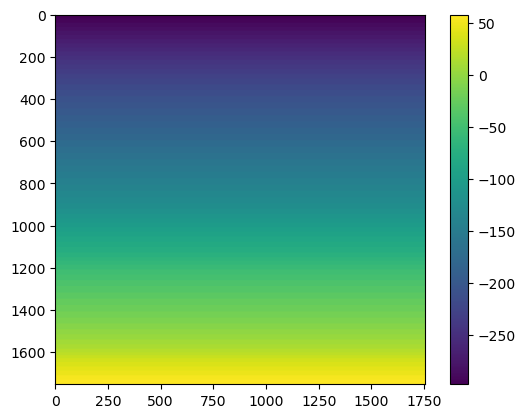

In [48]:
plt.imshow(xh1_matrix)
plt.colorbar()
plt.show()

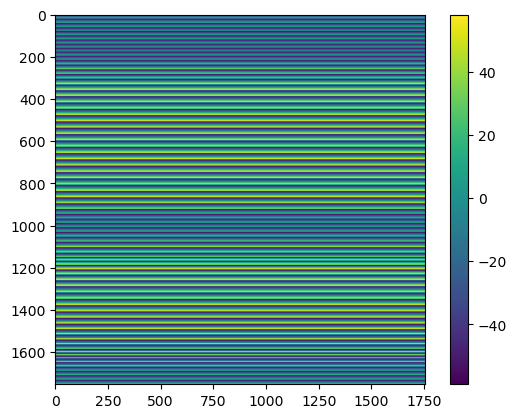

In [49]:
plt.imshow(yh1_matrix)
plt.colorbar()
plt.show()

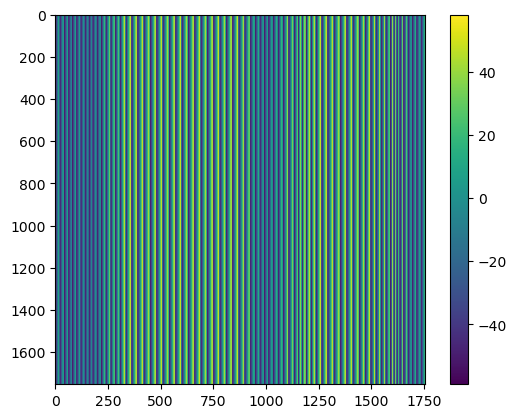

In [50]:
plt.imshow(yh2_matrix)
plt.colorbar()
plt.show()

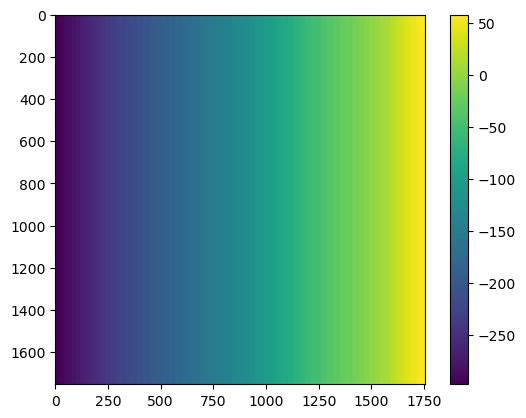

In [51]:
plt.imshow(xh2_matrix)
plt.colorbar()
plt.show()

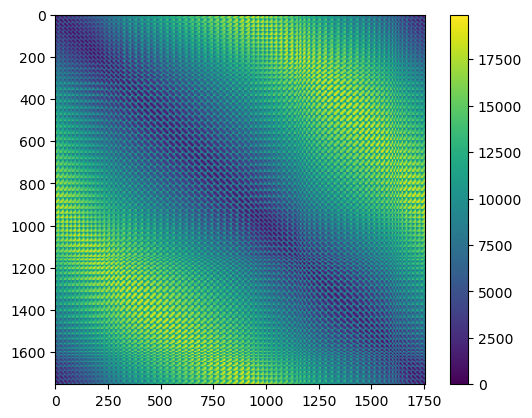

In [52]:
plt.imshow(d_matrix)
plt.colorbar()
plt.show()

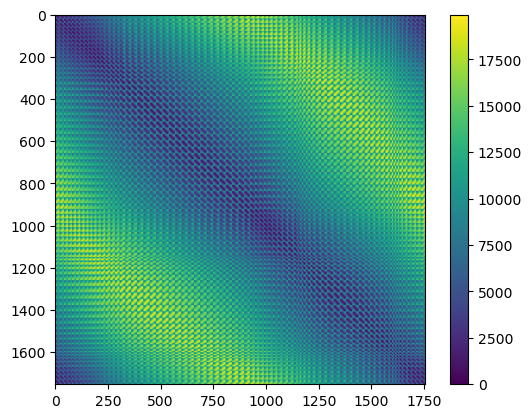

In [53]:
plt.imshow(hd_matrix)
plt.colorbar()
plt.show()

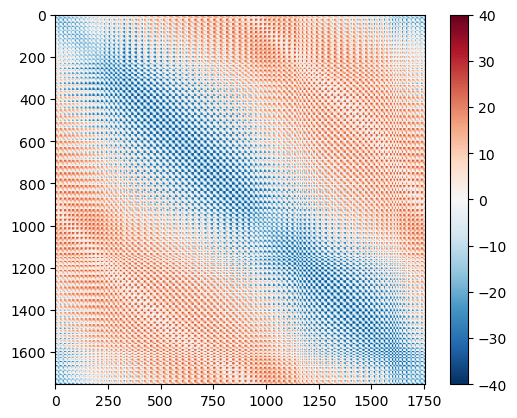

In [57]:
plt.imshow(d_matrix - hd_matrix,cmap='RdBu_r',vmin=-40,vmax=40)
plt.colorbar()

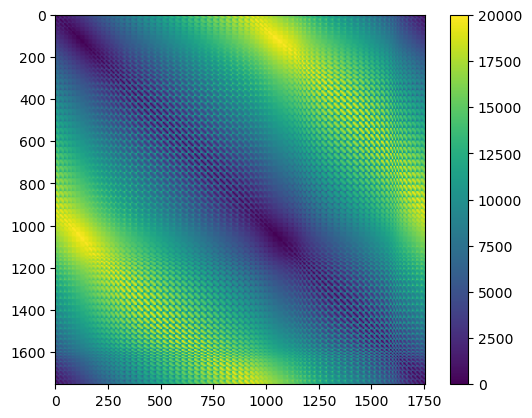

In [58]:
plt.imshow(haversine_distances(np.radians(keys_for_indexing)) * 6371)
plt.colorbar()

In [60]:
da_flat = subset.stack(location=('yh', 'xh')).transpose('location', 'time')
da_flattened = da_flat.dropna(dim='location', how='all')
coords = np.column_stack((da_flattened['yh'].values, da_flattened['xh'].values))
d = haversine_distances(np.radians(coords)) * 6371 

In [61]:
coords

array([[ -58.93494159, -297.36769634],
       [ -58.93494159, -292.40608222],
       [ -58.93494159, -287.443892  ],
       ...,
       [  58.02012462,   13.04910347],
       [  58.02012462,   18.00808522],
       [  58.02012462,   22.96578844]])

In [62]:
np.radians(coords)

array([[-1.02860878, -5.19004539],
       [-1.02860878, -5.10344889],
       [-1.02860878, -5.01684233],
       ...,
       [ 1.01264221,  0.22774982],
       [ 1.01264221,  0.31430038],
       [ 1.01264221,  0.40082862]])

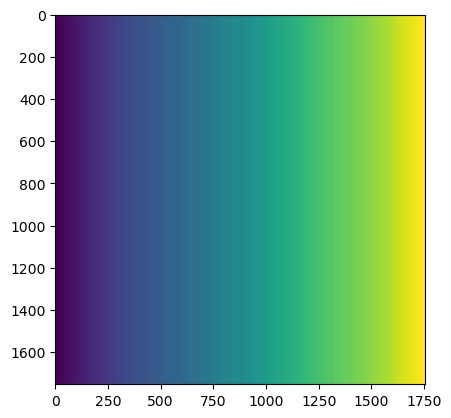

In [63]:
plt.imshow(np.tile([lon for lon, _ in keys_for_indexing], (len([lon for lon, _ in keys_for_indexing]), 1)))

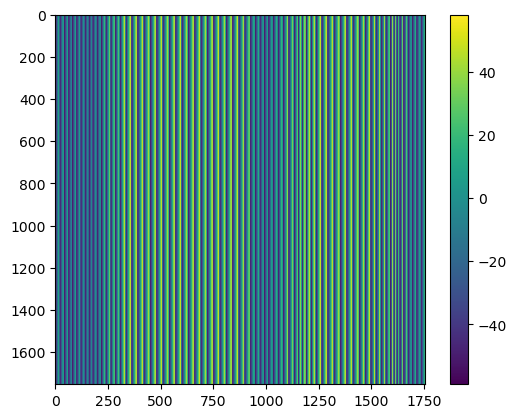

In [64]:
plt.imshow(np.tile([lat for _, lat in keys_for_indexing], (len([lat for _, lat in keys_for_indexing]), 1)))
plt.colorbar()

In [68]:
np.shape(d)

(1754, 1754)

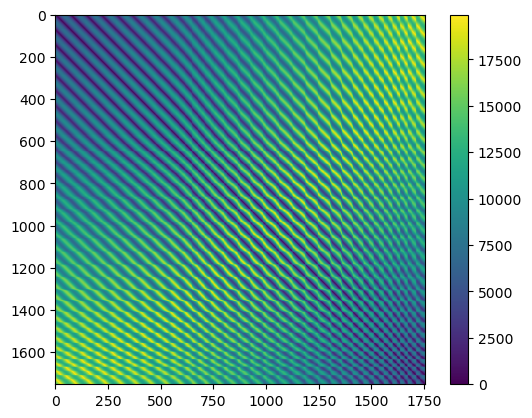

In [69]:
plt.imshow(d)
plt.colorbar()
plt.show()

In [70]:
# Calculate Pearson correlation matrix
r = da_flattened.to_pandas().T.corr(method='pearson')

In [71]:
np.shape(r.values)

(1754, 1754)

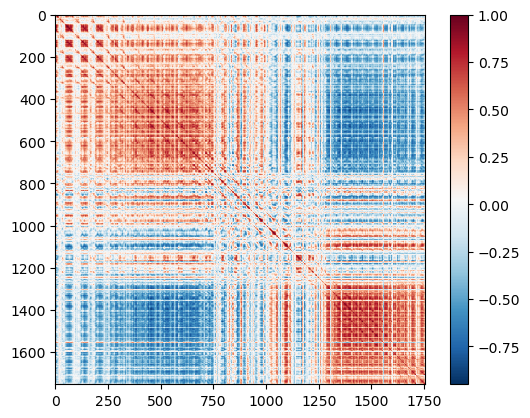

In [72]:
plt.imshow(r,cmap='RdBu_r')
plt.colorbar()
plt.show()

Constant to ensure the value of the exponential term is 0.5 when d = 3000  km.
$$ a = \sqrt{\frac{3000}{2 \ln(2)}} $$

In [73]:
# Define the scaling parameter 'a'
a = np.sqrt(3000/(2 * np.log(2)))  # Using 3000 km as given

In [74]:
print(a)

46.51927085986457


In [75]:
np.exp(-3000 / (2 * a ** 2))

0.5

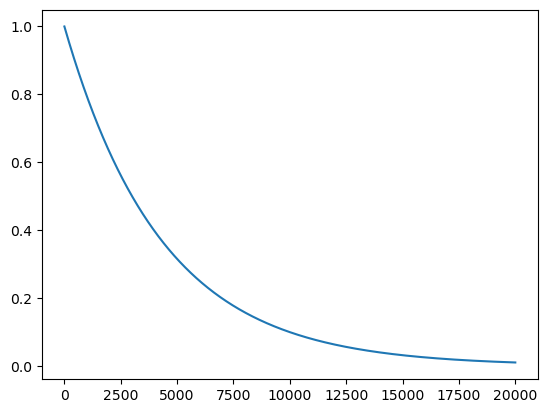

In [76]:
plt.plot(np.arange(0,2e4), np.exp(-np.arange(0,2e4) / (2 * a ** 2)))

## Distance
The ocean regions are deﬁned objectively using an agglomerative hierarchical cluster analysis (AHCA) [Johnson, 1967], which is an algorithm that groups a set of observations by iteratively pairing the two closest observations or groups based on some measure of “distance.” [...] 

The distance \(D\) between two grid locations (\(x_i, x_j\)) is given by

\begin{equation}
D(x_i, x_j) = 1 - \exp \left( -\frac{d(x_i, x_j)}{2a^2} \right) r(x_i, x_j),
\end{equation}

where $d$ is Euclidian distance, $r$ is the temporal correlation coefficient, and $a$ is a constant such that the value of the exponential is 0.5 when $d$ = 3000 km. The role of the distance function is to provide some user-defined measure of similarity between two locations, and the effect of the exponential is to preferentially cluster locations within ocean basins.

In [81]:
D = 1 - np.exp(-d / (2 * a ** 2)) * r.values

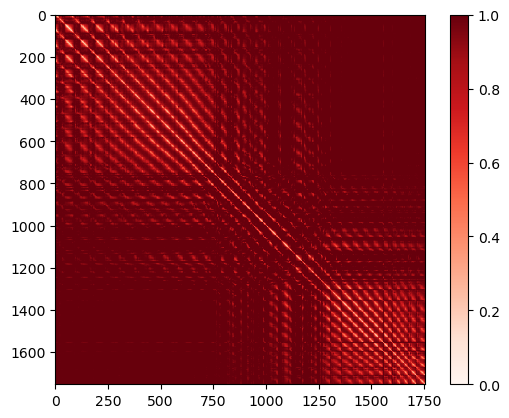

In [82]:
plt.imshow(D,cmap='Reds',vmin=0,vmax=1)
plt.colorbar()
plt.show()

In [83]:
from sklearn.cluster import AgglomerativeClustering

In [84]:
# Perform Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=6, metric='precomputed', linkage='average')
labels = xr.DataArray(clustering.fit_predict(D),  dims=['location'], coords={'location': da_flattened.location}).unstack('location')

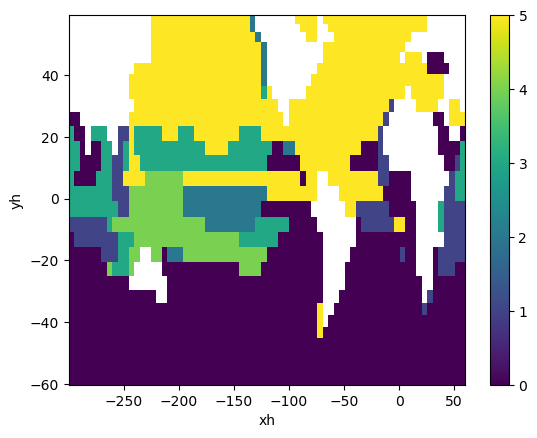

In [85]:
labels.plot()

### Array to be filled

In [50]:
nan_dataset_to_fill = ds_dataframe_nonnan.to_xarray()
nan_dataset_to_fill['zos'] = xr.DataArray(np.nan, coords=nan_dataset_to_fill['zos'].coords, 
                                dims=nan_dataset_to_fill['zos'].dims)

nan_dataset_to_fill = nan_dataset_to_fill.drop('time')
nan_dataset_to_fill = nan_dataset_to_fill.zos[0]

/vftmp/Jan-erik.Tesdal/pid9253/ipykernel_20125/1668452508.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  nan_dataset_to_fill = nan_dataset_to_fill.drop('time')


### Reloading the Saved Comparison Matrix
- can skip to here if you have the comparison matrix saved as a file 

In [107]:
file_path = 'comparison_matrix_saved.txt'
comparison_matrix = np.loadtxt(file_path)

### Inputting into Agglomerative Hierarchical Clustering Function

In [52]:
num_clusters = 6
#num_connections = 45
linkage='average'

#knn_graph = kneighbors_graph(comparison_matrix, num_connections, include_self=False)

clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage)
# Fit the clustering model with the distance matrix
#knn_graph = knn_graph.toarray()
clustering.fit(comparison_matrix)

# Retrieve the cluster labels assigned to each point
cluster_labels = clustering.labels_

# Print the cluster labels
print(cluster_labels)

/nbhome/ogrp/python/envs/py311_20240607/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:586: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


[0 0 0 ... 4 0 0]


### Making it plotable

In [53]:
unique_labels = np.unique(cluster_labels)
color_value = 0
list_to_array_slicing = np.array(keys_for_indexing)

for label in unique_labels:
    cluster_points = np.where(cluster_labels == label)[0]  # Get the indices of points in the current cluster
    # in the code below when we index using 0 and 1 that is the array of the xh and yh coords. We must now put these into an xarray dataset.
    group_xh = list_to_array_slicing[cluster_points, 0]
    group_yh = list_to_array_slicing[cluster_points, 1]
    
    for point_iterator in range(len(group_yh)):
        nan_dataset_to_fill.loc[{'xh': group_xh[point_iterator], 'yh': group_yh[point_iterator]}] = color_value
    
    color_value += 1
    

### Plotting and checking bounds 

In [ ]:
labels.plot()

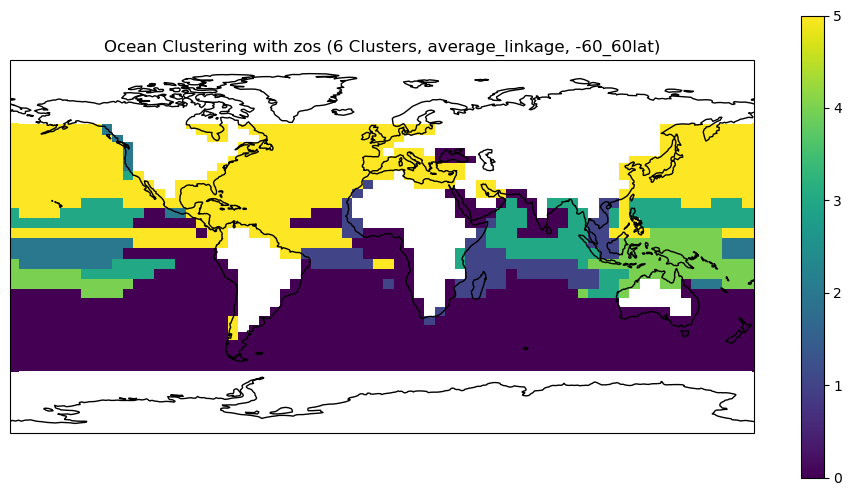

In [56]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})

# Plot the ocean boundaries using xarray.Dataset.plot()
labels.plot(ax=ax, transform=projection, cmap='viridis')
ax.set_title(f'Ocean Clustering with zos ({num_clusters} Clusters, {linkage}_linkage, {yh_min}_{yh_max}lat)')
ax.set_extent([-180, 180, -90, 90], crs=projection)
ax.coastlines()
#plt.savefig(f'clustering_6_11/{linkage}_linkage_{num_clusters}_clusters_{yh_min}_{yh_max}lat')

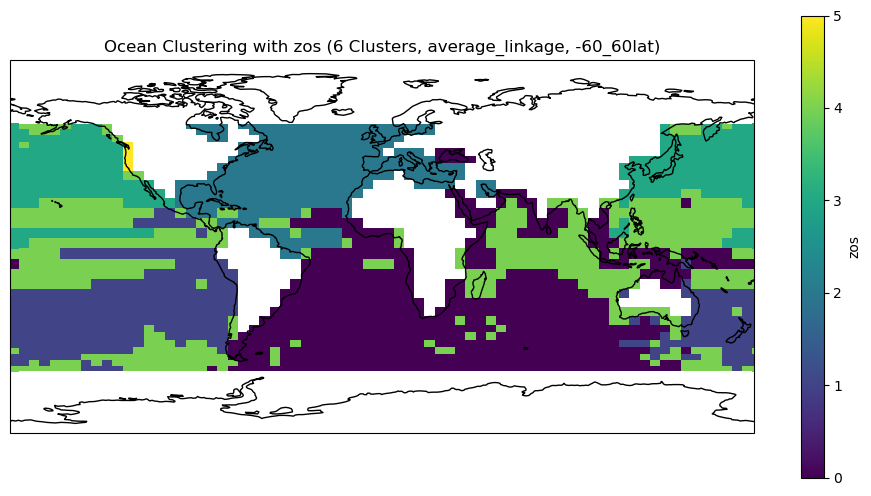

In [55]:
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})

# Plot the ocean boundaries using xarray.Dataset.plot()
nan_dataset_to_fill.plot(ax=ax, transform=projection, cmap='viridis')
ax.set_title(f'Ocean Clustering with zos ({num_clusters} Clusters, {linkage}_linkage, {yh_min}_{yh_max}lat)')
ax.set_extent([-180, 180, -90, 90], crs=projection)
ax.coastlines()
#plt.savefig(f'clustering_6_11/{linkage}_linkage_{num_clusters}_clusters_{yh_min}_{yh_max}lat')

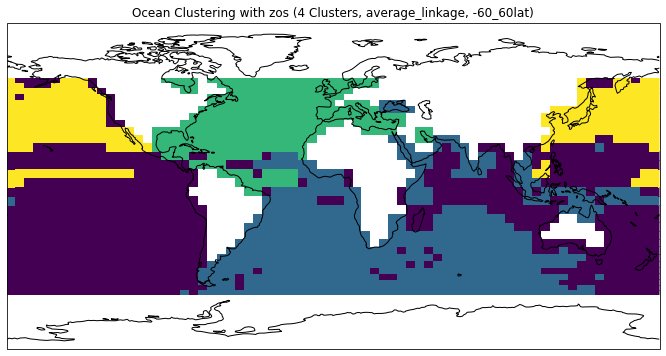

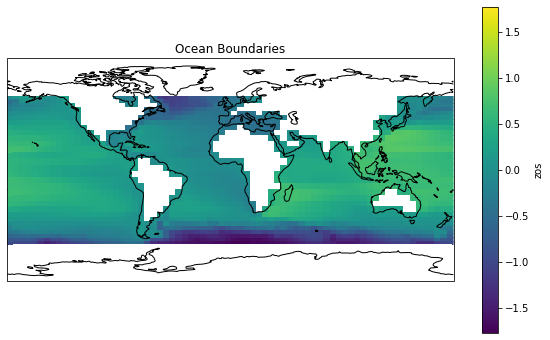

In [490]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

subset.mean(dim='time').plot(ax=ax, transform=projection, cmap='viridis', add_colorbar=True)
ax.set_title('Ocean Boundaries')
ax.set_extent([-180, 180, -90, 90], crs=projection)
ax.coastlines()